In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabula import read_pdf
import plotly.express as px
from itertools import islice, cycle
import cpi
cpi.update()

In [171]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import re

In [3]:
insurance = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/insurance.csv')
insurance_df = pd.DataFrame(insurance)
insurance_df
# we could run this through a ML algorithm (supervised) to predict the charges based on the rest of the variables

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


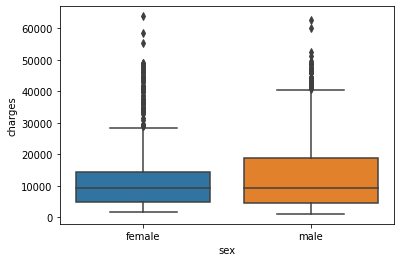

In [4]:
sns.boxplot(data=insurance, x='sex', y='charges');
# median cost for males and females is about the same
# variance in male cost is higher

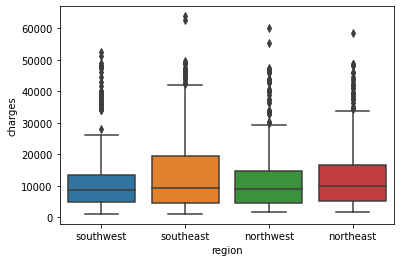

In [5]:
sns.boxplot(data=insurance, x='region', y='charges');
# median cost by region is the same across the country
# if mean and median are significantly off, the skewedness of the data would be worth mentioning


In [6]:
regional_ins = insurance_df.groupby(['region']).mean(['charges'])
regional_ins.reset_index(inplace=True)
regional_ins

,region,age,bmi,children,charges
0,northeast,39.268519,29.173503,1.046296,13406.384516
1,northwest,39.196923,29.199785,1.147692,12417.575374
2,southeast,38.939560,33.355989,1.049451,14735.411438
3,southwest,39.455385,30.596615,1.141538,12346.937377


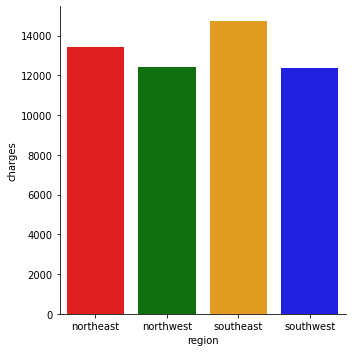

In [7]:
colors = { 'southwest': 'blue', 'southeast':'orange', 'northwest':'green', 'northeast': 'red'}
sns.catplot(data=regional_ins, x='region', y='charges', kind='bar', palette=colors);
# the mean and median are fairly consistent with each other

In [8]:
gender_ins = insurance_df.groupby(['sex']).mean(['charges'])
gender_ins.reset_index(inplace=True)


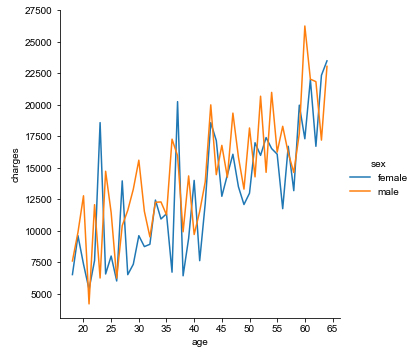

In [9]:
fig = sns.relplot(data=insurance_df, x='age', y='charges', kind='line', hue='sex', errorbar=None);
fig.set(xticks=np.arange(20,70,5), yticks=np.arange(5000,30000,2500))
sns.set(rc={'figure.figsize':(100,100)})

# make my own groups like binning the variables like age, bmi, etc

In [10]:
insurance_df.loc[insurance_df['age'].between(0, 30), 'group'] = 'young'
insurance_df.loc[insurance_df['age'].between(31, 50), 'group'] = 'GenX'
insurance_df.loc[insurance_df['age'].between(51, 70), 'group'] = 'boomer'
insurance_df

,age,sex,bmi,children,smoker,region,charges,group
0,19,female,27.900,0,yes,southwest,16884.92400,young
1,18,male,33.770,1,no,southeast,1725.55230,young
2,28,male,33.000,3,no,southeast,4449.46200,young
3,33,male,22.705,0,no,northwest,21984.47061,GenX
4,32,male,28.880,0,no,northwest,3866.85520,GenX
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,GenX
1334,18,female,31.920,0,no,northeast,2205.98080,young
1335,18,female,36.850,0,no,southeast,1629.83350,young
1336,21,female,25.800,0,no,southwest,2007.94500,young


In [11]:
group_avg = insurance_df.groupby(['group']).mean(['charges'])
group_avg.reset_index(inplace=True)
group_avg

,group,age,bmi,children,charges
0,GenX,40.747212,30.613076,1.444238,13280.774031
1,boomer,57.140449,31.703062,0.884831,18084.987223
2,young,22.961712,29.890766,0.840090,9397.552051


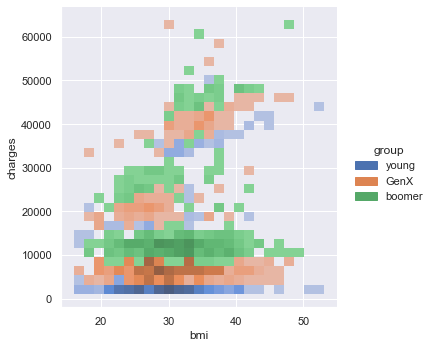

In [12]:
grp_plt = sns.displot(data=insurance_df, x='bmi', y='charges', hue='group')

# generally along the bottom of the graph, the densest concentrations of people show the older you are, generally the greater your insurance charges, although there are a 
# lot of data points above those three dense groups, but by and large boomers cost more than gen-x-ers cost more than young people

In [13]:
hospital_costs = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/HospitalCosts.csv')
hosp_costs_df = pd.DataFrame(hospital_costs)
hosp_costs_df.drop(['RACE'], axis=1, inplace=True)
hosp_costs_df.rename(columns={'AGE': 'age', 'FEMALE': 'female', 'LOS': 'length of stay', 'TOTCHG': 'total charge', 'APRDRG': 'all patient refined diagnosis related groups'}, inplace=True)
hosp_costs_df

,age,female,length of stay,total charge,all patient refined diagnosis related groups
0,17,1,2,2660,560
1,17,0,2,1689,753
2,17,1,7,20060,930
3,17,1,1,736,758
4,17,1,1,1194,754
...,...,...,...,...,...
495,0,1,6,5881,636
496,0,1,2,1171,640
497,0,1,2,1171,640
498,0,1,2,1086,640


In [14]:
hosp_costs_df['all patient refined diagnosis related groups'].unique()

array([560, 753, 930, 758, 754, 347, 751, 812, 566, 249, 422,  50, 139,
       141, 420,  97, 811, 755, 720,  53, 760, 710, 776, 115, 602, 138,
       137, 640, 639, 143, 254, 581, 633, 626, 636,  23,  57, 421, 580,
       750,  49,  51, 313, 614, 634, 952,  21,  92, 756, 317, 344, 114,
       206, 723, 911,  54, 225,  58, 740, 308, 204, 561, 863])

In [15]:
state_ins = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/state_insurance_coverage.csv')
state_ins_df = pd.DataFrame(state_ins)
state_ins_df
state_ins_df.insert(1, 'state_code', ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'US'])
state_ins_df

,State,state_code,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015),Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Average Monthly Tax Credit (2016),State Medicaid Expansion (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
0,Alabama,AL,14.6%,10.1%,-4.5%,215000,2545000,165534,152206,$310,False,799176.0,910775,111599.0,989855
1,Alaska,AK,19.9%,14.9%,-5%,36000,390000,17995,16205,$750,True,122334.0,166625,44291.0,88966
2,Arizona,AZ,16.9%,10.8%,-6.1%,410000,3288000,179445,124346,$230,True,1201770.0,1716198,514428.0,1175624
3,Arkansas,AR,17.5%,9.5%,-8%,234000,1365000,63357,56843,$306,True,556851.0,920194,363343.0,606146
4,California,CA,18.5%,8.6%,-9.9%,3826000,19552000,1415428,1239893,$309,True,7755381.0,11843081,4087700.0,5829777
5,Colorado,CO,15.9%,8.1%,-7.8%,419000,2949000,108311,67062,$318,True,783420.0,1375264,591844.0,820234
6,Connecticut,CT,9.1%,6%,-3.1%,110000,2148000,102917,80759,$357,True,NaN,761137,NaN,644136
7,Delaware,DE,9.7%,5.9%,-3.8%,35000,564000,25379,21467,$330,True,223324.0,236702,13378.0,186835
8,District of Columbia,DC,7.6%,3.8%,-3.8%,25000,388000,17666,1224,$183,True,235786.0,255491,19705.0,90492
9,Florida,FL,21.3%,13.3%,-8%,1597000,8847000,1531714,1428712,$305,False,3104996.0,3644673,539677.0,4149593


In [16]:
state_ins_df.describe()

,Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
count,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01,5.000000e+01,5.200000e+01,5.000000e+01,5.200000e+01
mean,7.479423e+05,6.626615e+06,4.262050e+05,3.611388e+05,2.255699e+06,2.828190e+06,6.442463e+05,2.173923e+06
std,2.691466e+06,2.370240e+07,1.538234e+06,1.306590e+06,7.945644e+06,1.017933e+07,2.306655e+06,7.855834e+06
min,1.500000e+04,3.350000e+05,1.331300e+04,1.224000e+03,6.751800e+04,6.358300e+04,-3.935000e+03,8.896600e+04
25%,9.725000e+04,8.797500e+05,5.109700e+04,4.371700e+04,2.897750e+05,3.091128e+05,5.397900e+04,3.208870e+05
50%,2.245000e+05,2.305500e+06,1.306725e+05,9.817550e+04,7.946135e+05,9.780525e+05,2.341560e+05,8.187530e+05
75%,4.122500e+05,4.386500e+06,2.260822e+05,1.936845e+05,1.274017e+06,1.732724e+06,4.562492e+05,1.298255e+06
max,1.930400e+07,1.722920e+08,1.108133e+07,9.389609e+06,5.639248e+07,7.353293e+07,1.610616e+07,5.714998e+07


In [17]:
state_med_exp = state_ins_df.loc[state_ins_df['State Medicaid Expansion (2016)'] == True]
a = state_med_exp.describe()
a

,Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
count,3.200000e+01,3.200000e+01,3.200000e+01,3.200000e+01,3.100000e+01,3.200000e+01,3.100000e+01,3.200000e+01
mean,3.960625e+05,3.410906e+06,1.630668e+05,1.304804e+05,1.201584e+06,1.609886e+06,4.356806e+05,1.074767e+06
std,6.714282e+05,3.912557e+06,2.506145e+05,2.185827e+05,1.651878e+06,2.256601e+06,7.137971e+05,1.182742e+06
min,1.500000e+04,3.450000e+05,1.331300e+04,1.224000e+03,6.998000e+04,8.976300e+04,1.337800e+04,8.896600e+04
25%,6.675000e+04,8.635000e+05,4.451850e+04,3.086700e+04,2.620715e+05,3.276932e+05,8.570700e+04,2.699808e+05
50%,2.595000e+05,2.221500e+06,9.139650e+04,6.926700e+04,6.263560e+05,1.036686e+06,3.633430e+05,8.006520e+05
75%,4.122500e+05,4.047500e+06,1.900825e+05,1.440155e+05,1.242810e+06,1.733281e+06,4.988730e+05,1.242056e+06
max,3.826000e+06,1.955200e+07,1.415428e+06,1.239893e+06,7.755381e+06,1.184308e+07,4.087700e+06,5.829777e+06


In [18]:
no_med_exp = state_ins_df.loc[state_ins_df['State Medicaid Expansion (2016)'] == False]
b = no_med_exp.describe()
b

,Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
count,1.900000e+01,1.900000e+01,1.900000e+01,1.900000e+01,1.800000e+01,1.900000e+01,18.000000,1.900000e+01
mean,3.639474e+05,3.323316e+06,3.085891e+05,2.744335e+05,1.063520e+06,1.158768e+06,144447.666667,1.131655e+06
std,4.931216e+05,3.284652e+06,3.885234e+05,3.516869e+05,1.107422e+06,1.226821e+06,173459.169592,1.115234e+06
min,1.900000e+04,3.350000e+05,2.207600e+04,2.031300e+04,6.751800e+04,6.358300e+04,-3935.000000,9.912800e+04
25%,1.230000e+05,1.213000e+06,8.488950e+04,7.453050e+04,3.150618e+05,3.040435e+05,25984.250000,3.408415e+05
50%,2.030000e+05,2.487000e+06,1.655340e+05,1.522060e+05,8.226300e+05,9.107750e+05,59003.000000,9.741140e+05
75%,3.220000e+05,4.185500e+06,3.154410e+05,2.724730e+05,1.179770e+06,1.336998e+06,215708.250000,1.329590e+06
max,1.781000e+06,1.370900e+07,1.531714e+06,1.428712e+06,4.441605e+06,4.770229e+06,539677.000000,4.149593e+06


## The mean of average monthly tax credits in 2016 is lower in states that expanded medicaid than in those that didn't
## for those that expanded medicaid, the minimum AMTC (average monthly tax credit) is lower than in states that didn't expand medicaid, but the maximum is much higher
## the 25th, 50th, and 75th percentiles are all lower than in states that did not expand medicaid
## the standard deviation is much higher in states that expanded medicaid than in those that did not, meaning those AMTC's vary more than in those that did not expand medicaid
## it should be noted the maximum and std are higher in states that did expand medicaid because of one outlier at 750 in Alaska

In [19]:
state_ins_df['Average Monthly Tax Credit (2016)'] = state_ins_df['Average Monthly Tax Credit (2016)'].astype(object).astype('string')
state_ins_df['Average Monthly Tax Credit (2016)'] = state_ins_df['Average Monthly Tax Credit (2016)'].str.strip('$').astype(int)
state_ins_df

,State,state_code,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015),Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Average Monthly Tax Credit (2016),State Medicaid Expansion (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
0,Alabama,AL,14.6%,10.1%,-4.5%,215000,2545000,165534,152206,310,False,799176.0,910775,111599.0,989855
1,Alaska,AK,19.9%,14.9%,-5%,36000,390000,17995,16205,750,True,122334.0,166625,44291.0,88966
2,Arizona,AZ,16.9%,10.8%,-6.1%,410000,3288000,179445,124346,230,True,1201770.0,1716198,514428.0,1175624
3,Arkansas,AR,17.5%,9.5%,-8%,234000,1365000,63357,56843,306,True,556851.0,920194,363343.0,606146
4,California,CA,18.5%,8.6%,-9.9%,3826000,19552000,1415428,1239893,309,True,7755381.0,11843081,4087700.0,5829777
5,Colorado,CO,15.9%,8.1%,-7.8%,419000,2949000,108311,67062,318,True,783420.0,1375264,591844.0,820234
6,Connecticut,CT,9.1%,6%,-3.1%,110000,2148000,102917,80759,357,True,NaN,761137,NaN,644136
7,Delaware,DE,9.7%,5.9%,-3.8%,35000,564000,25379,21467,330,True,223324.0,236702,13378.0,186835
8,District of Columbia,DC,7.6%,3.8%,-3.8%,25000,388000,17666,1224,183,True,235786.0,255491,19705.0,90492
9,Florida,FL,21.3%,13.3%,-8%,1597000,8847000,1531714,1428712,305,False,3104996.0,3644673,539677.0,4149593


In [20]:
state_ins_df.dtypes

State                                            object
state_code                                       object
Uninsured Rate (2010)                            object
Uninsured Rate (2015)                            object
Uninsured Rate Change (2010-2015)                object
Health Insurance Coverage Change (2010-2015)      int64
Employer Health Insurance Coverage (2015)         int64
Marketplace Health Insurance Coverage (2016)      int64
Marketplace Tax Credits (2016)                    int64
Average Monthly Tax Credit (2016)                 int64
State Medicaid Expansion (2016)                  object
Medicaid Enrollment (2013)                      float64
Medicaid Enrollment (2016)                        int64
Medicaid Enrollment Change (2013-2016)          float64
Medicare Enrollment (2016)                        int64
dtype: object

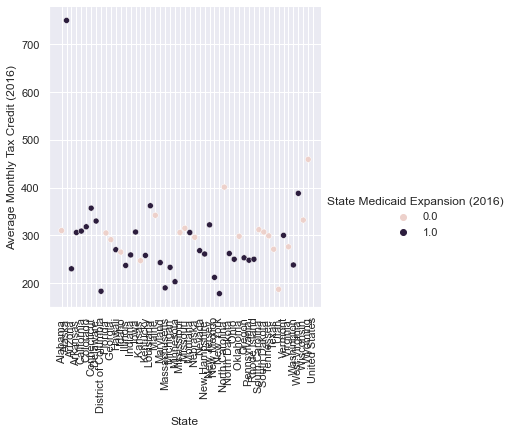

In [21]:
sns.relplot(data = state_ins_df, x='State', y='Average Monthly Tax Credit (2016)', hue='State Medicaid Expansion (2016)')
plt.xticks(rotation=90);
# generally it appears that states that did not expand medicaid are granting larger tax credits than those that did

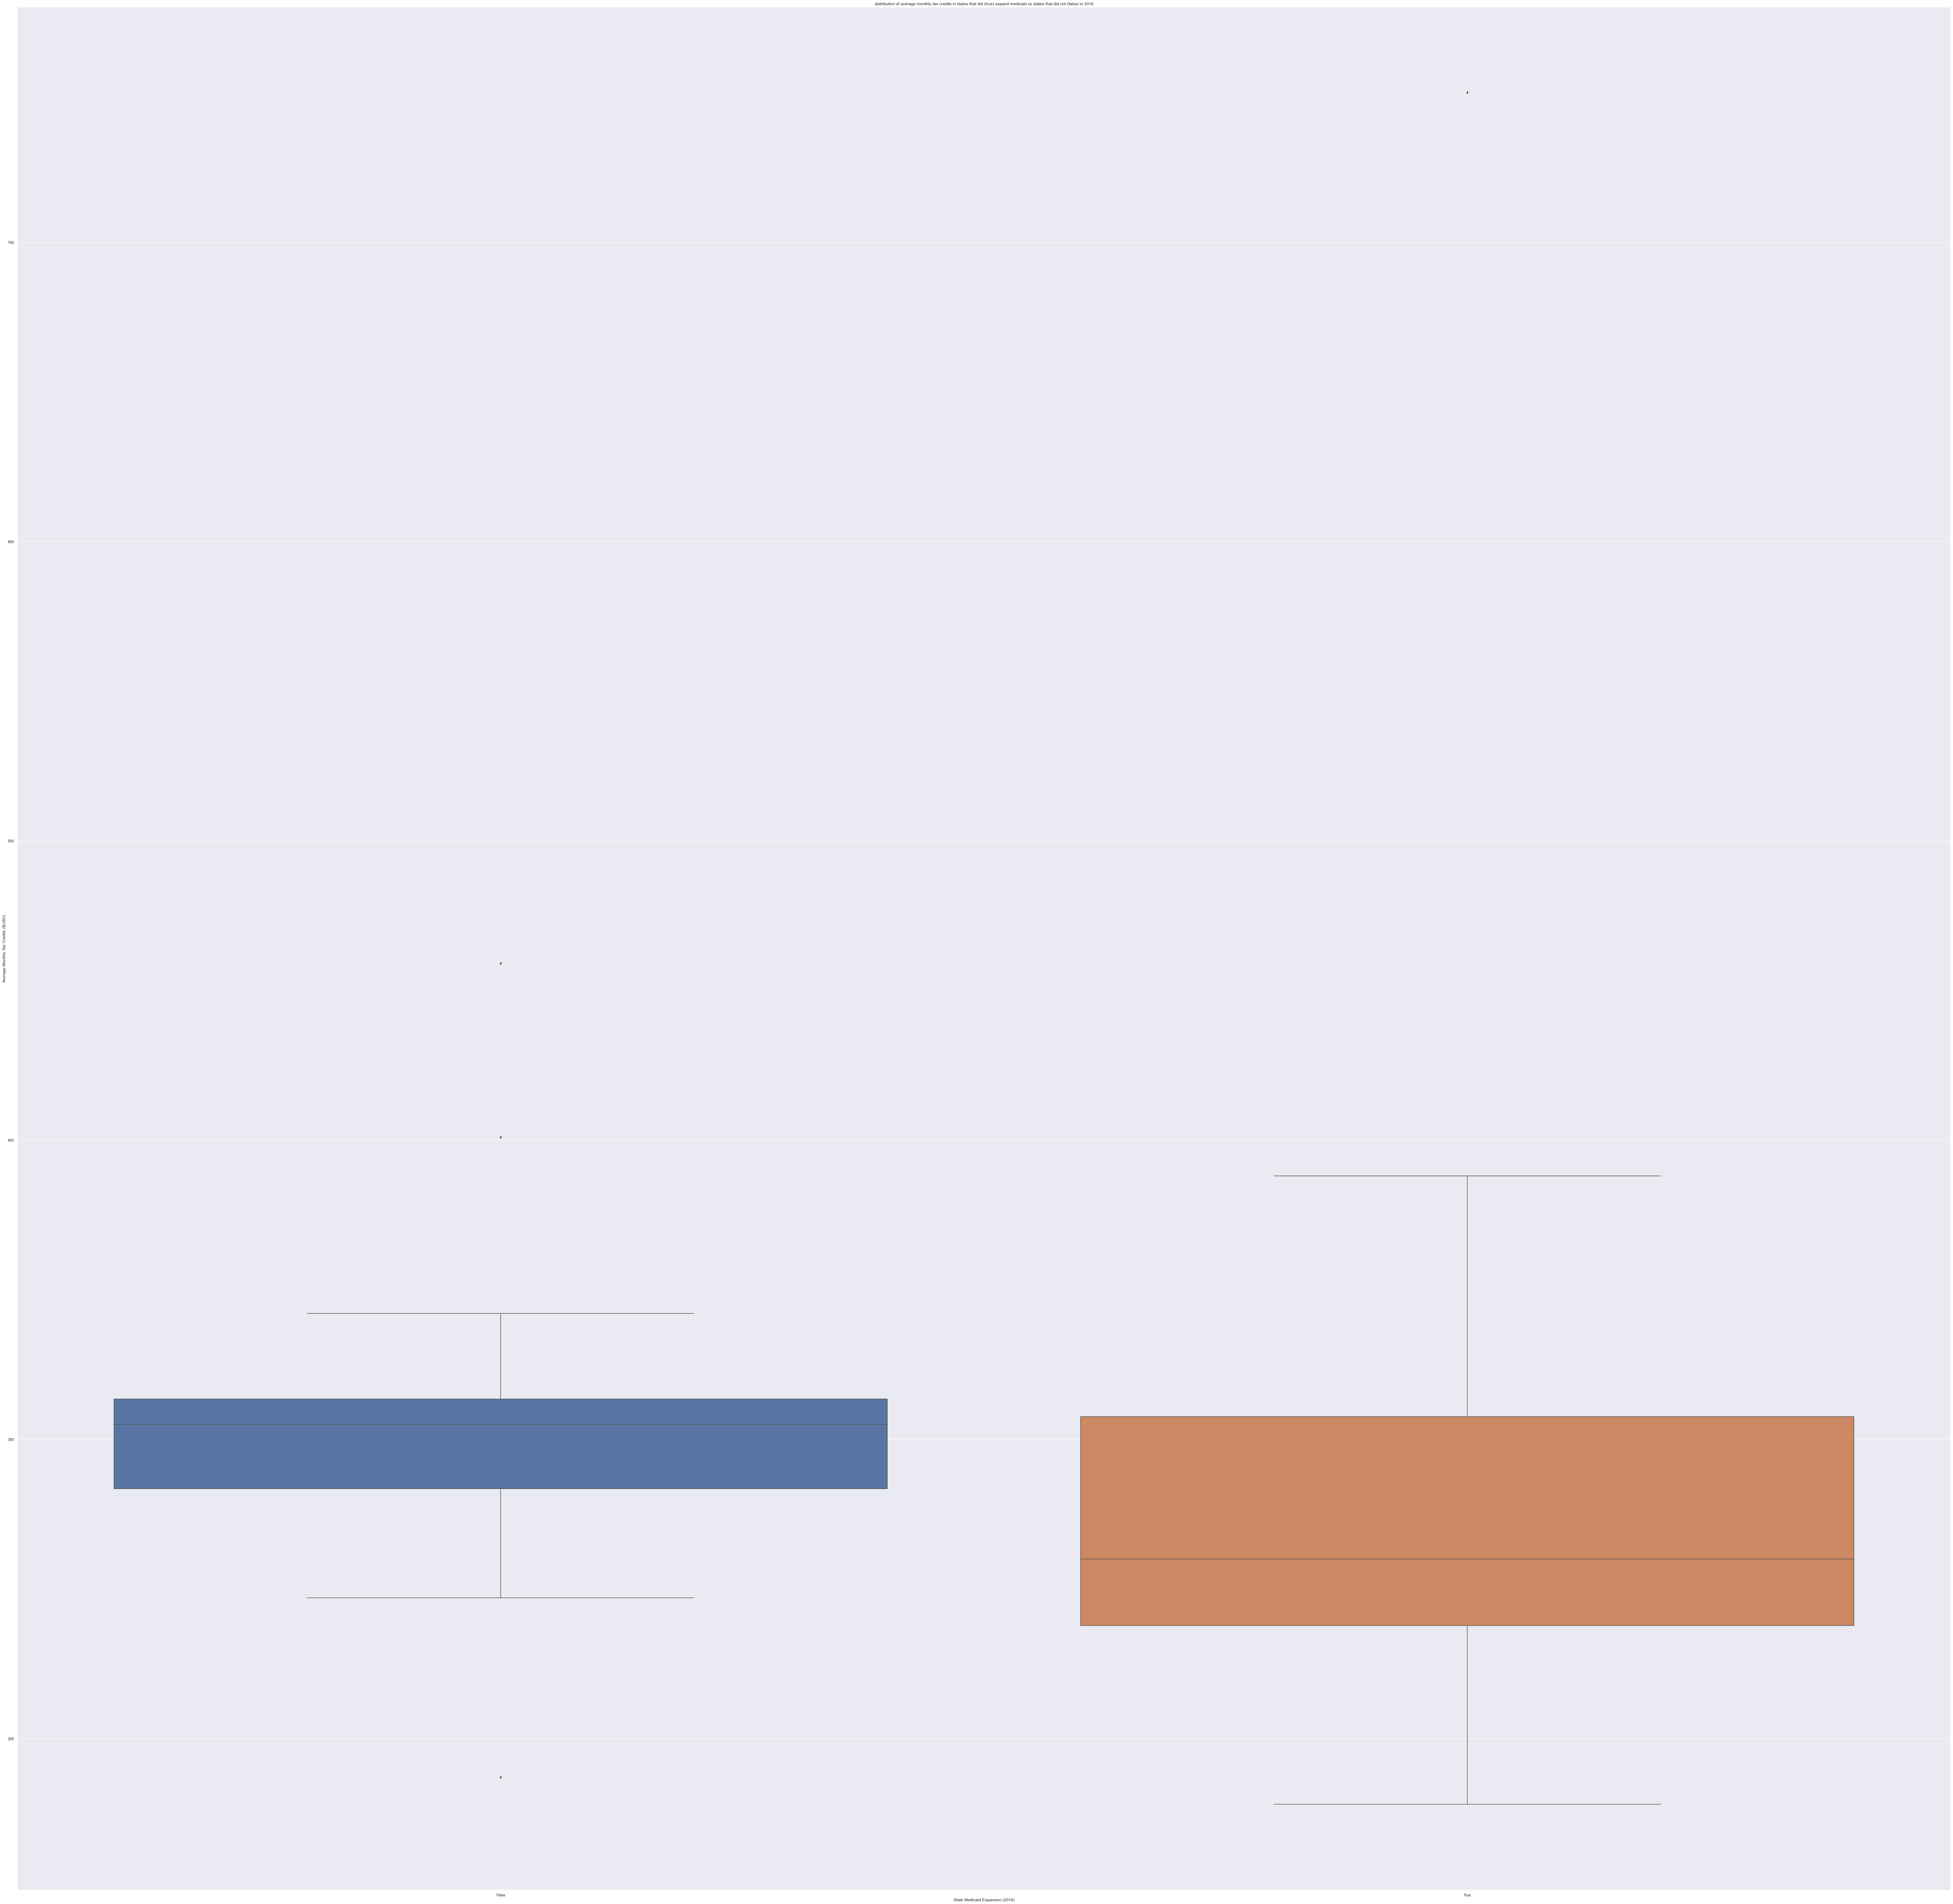

In [22]:
sns.boxplot(data=state_ins_df, x='State Medicaid Expansion (2016)', y='Average Monthly Tax Credit (2016)')
sns.set(rc={'figure.figsize':(9,9)})
plt.ylabel('Average Monthly Tax Credits ($USD)')
plt.title('distribution of average monthly tax credits in states that did (true) expand medicaid vs states that did not (false) in 2016');

## the median monthly tax credit was much lower in states that expanded medicaid than those that didn't

In [23]:
px.choropleth(state_ins_df,
                    locations="state_code",
                    locationmode='USA-states',
                    scope='usa',
                    color='Medicaid Enrollment Change (2013-2016)',
                    color_continuous_scale='thermal',
                    range_color=[-4000, 2000000]
                    )

## All states except Nebraska, Oklahoma, and Wyoming increased their medicaid enrollment between 2013-2016
## those three states reduced their medicaid enrollments during that timeframe

In [24]:
insurance_df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [25]:
# feateures
X = insurance_df.drop(['charges'], axis=1)
# target
y = insurance_df['charges']

In [26]:
X = pd.get_dummies(X, columns=['sex', 'children', 'smoker', 'region', 'group'])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [28]:
regressor = DecisionTreeRegressor(random_state=0)

regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [29]:
y_pred = regressor.predict(X_test)

In [30]:
test_df = pd.DataFrame({'Real Values': y_test, 'Predicted Values': y_pred})
test_df

,Real Values,Predicted Values
18,10602.38500,11365.95200
766,8062.76400,8765.24900
568,11552.90400,9872.70100
456,11881.96960,11187.65670
190,12557.60530,12146.97100
...,...,...
562,2494.02200,2498.41440
337,13937.66650,30166.61817
78,2755.02095,2217.46915
1100,16776.30405,18972.49500


In [31]:
important = sorted(zip(X.columns, regressor.feature_importances_), key=lambda x: x[1], reverse=True)
important

[('smoker_no', 0.6217894707531416),
 ('bmi', 0.19899493395563006),
 ('age', 0.1276408822938154),
 ('children_0', 0.011434301684148624),
 ('children_4', 0.005289498865855442),
 ('sex_male', 0.004818926048224203),
 ('children_2', 0.004251087570841335),
 ('children_1', 0.004167917017866859),
 ('region_northeast', 0.004131926546509002),
 ('region_southwest', 0.0039458107312244995),
 ('region_southeast', 0.0035810309561001776),
 ('region_northwest', 0.0023071519927133047),
 ('sex_female', 0.00205972769002154),
 ('group_GenX', 0.0020355079279140847),
 ('children_3', 0.0019629300191948175),
 ('group_young', 0.0013459504702415192),
 ('children_5', 0.00021490009630071468),
 ('group_boomer', 2.8045380256653137e-05),
 ('smoker_yes', 0.0)]

## In this model, being a smoker, body mass index, and age are the greatest determining factors in determining insurance charges
## sex, children, and region play very little to no part in determining the insurance charges

In [63]:
medicaid_agg = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/residence state estimates/MEDICAID_AGGREGATE20.CSV')
med_agg_df = pd.DataFrame(medicaid_agg)
med_agg_df

,Code,Item,Group,Region_Number,Region_Name,State_Name,Y1991,Y1992,Y1993,Y1994,...,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Average_Annual_Percent_Growth
0,1,Medicaid/Personal Health Care (Millions of Dol...,United States,0,United States,NaN,88921,103417,116453,126856,...,388256,405666,446921,484506,503382,516067,531782,552953,586914,6.7
1,1,Medicaid/Personal Health Care (Millions of Dol...,Region,1,New England,NaN,6676,7418,7768,8896,...,25512,26113,28519,30368,31616,31577,32910,32767,34183,5.8
2,1,Medicaid/Personal Health Care (Millions of Dol...,Region,2,Mideast,NaN,24821,28301,30979,33776,...,87340,88864,97912,103253,109981,117574,122226,123410,125408,5.7
3,1,Medicaid/Personal Health Care (Millions of Dol...,Region,3,Great Lakes,NaN,13820,16525,18627,19492,...,52941,56964,62039,66741,68168,70092,70563,74817,83497,6.4
4,1,Medicaid/Personal Health Care (Millions of Dol...,Region,4,Plains,NaN,5548,6569,7205,7910,...,25535,26266,27973,29466,30255,31077,32582,33444,34551,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,10,"Medicaid/Other Health, Residential, and Person...",State,5,Southeast,Virginia,218,236,259,285,...,2165,2308,2313,2498,2692,2756,2553,2380,2437,8.7
596,10,"Medicaid/Other Health, Residential, and Person...",State,8,Far West,Washington,314,359,398,358,...,1459,1721,1487,1855,2301,2566,3126,3315,3832,9.0
597,10,"Medicaid/Other Health, Residential, and Person...",State,5,Southeast,West Virginia,55,77,136,198,...,664,664,682,650,578,603,578,647,608,8.6
598,10,"Medicaid/Other Health, Residential, and Person...",State,3,Great Lakes,Wisconsin,381,446,450,439,...,1011,1029,1149,1048,990,1082,1206,1307,1466,4.8


## you could show which of these services are most utilized 

In [33]:
hospital_care = med_agg_df.loc[med_agg_df['Item'] == 'Medicaid/Hospital Care (Millions of Dollars)']
hospital_care['Region_Number'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [34]:
medicaid_enrollment = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/residence state estimates/MEDICAID_ENROLLMENT20.CSV')
med_enr_df = pd.DataFrame(medicaid_enrollment)
med_enr_df.rename(columns={'REGION_NAME':'Region_Name'}, inplace=True)
med_enr_df['Item'].unique()

array(['Medicaid Enrollee Population (Thousands)'], dtype=object)

In [35]:
medicaid_per_enrollee = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/residence state estimates/MEDICARE_PER_ENROLLEE20.CSV')
mpe_df = pd.DataFrame(medicaid_per_enrollee)
mpe_df.head()

,Code,Item,Group,Region_Number,Region_Name,State_Name,Y1991,Y1992,Y1993,Y1994,...,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Average_Annual_Percent_Growth
0,1,Medicare/Personal Health Care ($),United States,0,United States,NaN,3431,3796,4108,4511,...,10741,10796,10965,11168,11279,11529,11871,12372,12271,4.5
1,1,Medicare/Personal Health Care ($),Region,1,New England,NaN,3539,3949,4334,4717,...,10799,10884,11167,11398,11521,11699,11991,12419,12011,4.3
2,1,Medicare/Personal Health Care ($),Region,2,Mideast,NaN,3937,4198,4580,4918,...,11625,11694,11910,12100,12177,12377,12691,13138,12876,4.2
3,1,Medicare/Personal Health Care ($),Region,3,Great Lakes,NaN,3244,3614,3854,4244,...,10614,10704,10869,10972,11076,11339,11646,12087,11886,4.6
4,1,Medicare/Personal Health Care ($),Region,4,Plains,NaN,2867,3187,3388,3691,...,9553,9680,9946,10174,10269,10664,11018,11363,11291,4.8


## Medicaid is for people with limited income/resources
## Medicare is for people primarily over 65 y/o but also for people with terminal diseases such as ALS or end-stage renal disease

## Take the above datasets for medicare and medicaid and look at those items vs a states' obesity rate, education level, avg cost of procedures, avg age of the state/region, smoking rate, and perhaps look at this data broken down by gender

In [36]:
us_per_capita = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/residence state estimates/US_PER_CAPITA20.CSV')
us_pc_df = pd.DataFrame(us_per_capita)
us_pc_df

,Code,Item,Group,Region_Number,Region_Name,State_Name,Y1991,Y1992,Y1993,Y1994,...,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Average_Annual_Percent_Growth
0,1,Personal Health Care ($),United States,0,United States,NaN,2659,2840,2984,3109,...,7477,7611,7938,8337,8652,8936,9246,9671,10191,4.7
1,1,Personal Health Care ($),Region,1,New England,NaN,3093,3293,3484,3619,...,9484,9660,9990,10516,10940,11221,11643,12123,12728,5.0
2,1,Personal Health Care ($),Region,2,Mideast,NaN,3066,3296,3480,3656,...,8735,8967,9375,9840,10338,10797,11273,11836,12577,5.0
3,1,Personal Health Care ($),Region,3,Great Lakes,NaN,2646,2827,2982,3117,...,7672,7806,8143,8481,8797,9050,9291,9754,10221,4.8
4,1,Personal Health Care ($),Region,4,Plains,NaN,2565,2725,2863,3048,...,7794,7907,8192,8547,8852,9066,9381,9765,10285,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,10,"Other Health, Residential, and Personal Care ($)",State,5,Southeast,Virginia,51,57,65,76,...,386,402,419,446,469,493,486,480,491,8.1
596,10,"Other Health, Residential, and Personal Care ($)",State,8,Far West,Washington,91,86,95,99,...,354,388,383,439,512,554,616,656,714,7.4
597,10,"Other Health, Residential, and Personal Care ($)",State,5,Southeast,West Virginia,100,106,137,187,...,658,654,670,653,606,602,600,640,637,6.6
598,10,"Other Health, Residential, and Personal Care ($)",State,3,Great Lakes,Wisconsin,141,139,153,163,...,366,377,384,399,398,422,443,455,486,4.4


In [37]:
a = us_pc_df.iloc[:,31:36]
b = a.pct_change(axis=1)
b['Avg_Pct_Growth_2016_20'] = b.mean(axis=1)
b_avg = b['Avg_Pct_Growth_2016_20']
b_avg

0      0.041813
1      0.038606
2      0.050258
3      0.038275
4      0.038276
         ...   
595    0.011886
596    0.086824
597    0.013014
598    0.051321
599    0.047998
Name: Avg_Pct_Growth_2016_20, Length: 600, dtype: float64

In [38]:
full_us_percap_df = pd.concat([us_pc_df, b_avg], axis=1)
full_us_percap_df['Item'].unique()

array(['Personal Health Care ($)', 'Hospital Care ($)',
       'Physician & Clinical Services ($)',
       'Other Professional Services ($)', 'Dental Services ($)',
       'Home Health Care ($)',
       'Prescription Drugs and Other Non-durable Medical Products ($)',
       'Durable Medical Products ($)', 'Nursing Home Care ($)',
       'Other Health, Residential, and Personal Care ($)'], dtype=object)

In [39]:
full_us_percap_states_df = full_us_percap_df.dropna()
full_us_percap_states_df

,Code,Item,Group,Region_Number,Region_Name,State_Name,Y1991,Y1992,Y1993,Y1994,...,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Average_Annual_Percent_Growth,Avg_Pct_Growth_2016_20
9,1,Personal Health Care ($),State,5,Southeast,Alabama,2523,2704,2841,2970,...,6969,7277,7657,7968,8154,8343,8741,9280,4.6,0.038973
10,1,Personal Health Care ($),State,8,Far West,Alaska,2553,2634,2755,2992,...,10085,10535,11460,11761,12303,12695,13226,13642,5.9,0.037807
11,1,Personal Health Care ($),State,6,Southwest,Arizona,2434,2493,2610,2666,...,6289,6561,6885,7189,7539,7816,8145,8756,4.5,0.050634
12,1,Personal Health Care ($),State,5,Southeast,Arkansas,2351,2480,2597,2714,...,6819,7284,7620,8079,8409,8545,8853,9338,4.9,0.036962
13,1,Personal Health Care ($),State,8,Far West,California,2659,2827,2931,2984,...,7241,7472,7998,8325,8594,9069,9628,10299,4.8,0.054729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,10,"Other Health, Residential, and Personal Care ($)",State,5,Southeast,Virginia,51,57,65,76,...,402,419,446,469,493,486,480,491,8.1,0.011886
596,10,"Other Health, Residential, and Personal Care ($)",State,8,Far West,Washington,91,86,95,99,...,388,383,439,512,554,616,656,714,7.4,0.086824
597,10,"Other Health, Residential, and Personal Care ($)",State,5,Southeast,West Virginia,100,106,137,187,...,654,670,653,606,602,600,640,637,6.6,0.013014
598,10,"Other Health, Residential, and Personal Care ($)",State,3,Great Lakes,Wisconsin,141,139,153,163,...,377,384,399,398,422,443,455,486,4.4,0.051321


In [40]:
state_codes = pd.Series(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'])
state_codes

0     AL
1     AK
2     AZ
3     AR
4     CA
5     CO
6     CT
7     DE
8     DC
9     FL
10    GA
11    HI
12    ID
13    IL
14    IN
15    IA
16    KS
17    KY
18    LA
19    ME
20    MD
21    MA
22    MI
23    MN
24    MS
25    MO
26    MT
27    NE
28    NV
29    NH
30    NJ
31    NM
32    NY
33    NC
34    ND
35    OH
36    OK
37    OR
38    PA
39    RI
40    SC
41    SD
42    TN
43    TX
44    UT
45    VT
46    VA
47    WA
48    WV
49    WI
50    WY
dtype: object

In [41]:
full_us_percap_states_df

,Code,Item,Group,Region_Number,Region_Name,State_Name,Y1991,Y1992,Y1993,Y1994,...,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Average_Annual_Percent_Growth,Avg_Pct_Growth_2016_20
9,1,Personal Health Care ($),State,5,Southeast,Alabama,2523,2704,2841,2970,...,6969,7277,7657,7968,8154,8343,8741,9280,4.6,0.038973
10,1,Personal Health Care ($),State,8,Far West,Alaska,2553,2634,2755,2992,...,10085,10535,11460,11761,12303,12695,13226,13642,5.9,0.037807
11,1,Personal Health Care ($),State,6,Southwest,Arizona,2434,2493,2610,2666,...,6289,6561,6885,7189,7539,7816,8145,8756,4.5,0.050634
12,1,Personal Health Care ($),State,5,Southeast,Arkansas,2351,2480,2597,2714,...,6819,7284,7620,8079,8409,8545,8853,9338,4.9,0.036962
13,1,Personal Health Care ($),State,8,Far West,California,2659,2827,2931,2984,...,7241,7472,7998,8325,8594,9069,9628,10299,4.8,0.054729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,10,"Other Health, Residential, and Personal Care ($)",State,5,Southeast,Virginia,51,57,65,76,...,402,419,446,469,493,486,480,491,8.1,0.011886
596,10,"Other Health, Residential, and Personal Care ($)",State,8,Far West,Washington,91,86,95,99,...,388,383,439,512,554,616,656,714,7.4,0.086824
597,10,"Other Health, Residential, and Personal Care ($)",State,5,Southeast,West Virginia,100,106,137,187,...,654,670,653,606,602,600,640,637,6.6,0.013014
598,10,"Other Health, Residential, and Personal Care ($)",State,3,Great Lakes,Wisconsin,141,139,153,163,...,377,384,399,398,422,443,455,486,4.4,0.051321


In [150]:
full_us_percap_hospcare_df = full_us_percap_df.loc[full_us_percap_df['Item'] == 'Hospital Care ($)'].dropna()
full_us_percap_hospcare_df.insert(6, 'state_code', ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'])
full_us_percap_hospcare_df

,Code,Item,Group,Region_Number,Region_Name,State_Name,state_code,Y1991,Y1992,Y1993,...,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Average_Annual_Percent_Growth,Avg_Pct_Growth_2016_20
69,2,Hospital Care ($),State,5,Southeast,Alabama,AL,1092,1201,1225,...,2515,2554,2644,2773,2844,2912,3117,3350,3.9,0.048666
70,2,Hospital Care ($),State,8,Far West,Alaska,AK,1105,1155,1210,...,4046,4213,4766,4770,4932,4892,4964,4802,5.2,0.001984
71,2,Hospital Care ($),State,6,Southwest,Arizona,AZ,901,938,950,...,2349,2388,2495,2611,2760,2854,2977,3263,4.5,0.057573
72,2,Hospital Care ($),State,5,Southeast,Arkansas,AR,1008,1070,1102,...,2559,2679,2849,3067,3247,3265,3459,3672,4.6,0.046307
73,2,Hospital Care ($),State,8,Far West,California,CA,981,1038,1074,...,2701,2753,2984,3097,3188,3419,3642,3838,4.8,0.055221
74,2,Hospital Care ($),State,7,Rocky Mountains,Colorado,CO,963,1012,1016,...,2449,2546,2662,2705,2817,2994,3108,3163,4.2,0.040003
75,2,Hospital Care ($),State,1,New England,Connecticut,CT,1178,1246,1284,...,3168,3194,3301,3441,3539,3716,3917,4308,4.6,0.058101
76,2,Hospital Care ($),State,2,Mideast,Delaware,DE,1165,1242,1351,...,3942,4111,4288,4293,4606,4868,5070,5377,5.4,0.057960
77,2,Hospital Care ($),State,2,Mideast,District of Columbia,DC,2413,2662,2834,...,5057,5079,5193,5233,5223,5308,5496,5652,3.0,0.019541
78,2,Hospital Care ($),State,5,Southeast,Florida,FL,1109,1169,1210,...,2503,2612,2697,2746,2844,2981,3107,3196,3.7,0.038693


In [43]:
full_us_percap_df.dropna(inplace=True)
full_us_percap_phc_df = full_us_percap_df.loc[full_us_percap_df['Item'] == 'Personal Health Care ($)']
full_us_percap_phc_df.insert(6, 'state_code', ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'])
full_us_percap_phc_df.describe()

,Code,Region_Number,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,...,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Average_Annual_Percent_Growth,Avg_Pct_Growth_2016_20
count,51.0,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1.0,4.470588,2588.960784,2764.666667,2909.176471,3046.627451,3212.784314,3368.901961,3535.294118,3703.019608,...,7864.862745,8208.431373,8608.725490,8927.392157,9225.803922,9529.235294,9940.509804,10477.078431,4.931373,0.040803
std,0.0,2.194110,407.895769,463.001022,489.979090,498.771128,511.085406,520.557519,524.512051,547.938591,...,1225.659398,1254.674942,1325.174722,1367.261512,1418.120743,1482.118195,1551.467285,1633.645688,0.424495,0.007952
min,1.0,1.000000,1966.000000,2055.000000,2173.000000,2221.000000,2333.000000,2487.000000,2684.000000,2746.000000,...,5554.000000,5825.000000,6112.000000,6398.000000,6628.000000,7008.000000,7193.000000,7522.000000,4.000000,0.028531
25%,1.0,3.000000,2351.500000,2504.500000,2614.500000,2760.500000,2897.000000,3027.500000,3200.000000,3357.000000,...,7048.500000,7326.000000,7702.000000,8014.000000,8227.000000,8421.000000,8785.500000,9308.000000,4.700000,0.036116
50%,1.0,5.000000,2530.000000,2704.000000,2857.000000,2984.000000,3127.000000,3332.000000,3507.000000,3681.000000,...,7638.000000,7965.000000,8344.000000,8630.000000,8940.000000,9168.000000,9635.000000,10212.000000,4.900000,0.038446
75%,1.0,6.000000,2673.000000,2864.500000,3037.500000,3198.000000,3336.500000,3517.500000,3691.500000,3879.000000,...,8693.000000,9055.500000,9522.500000,9979.500000,10315.000000,10564.500000,11081.500000,11648.500000,5.200000,0.044530
max,1.0,8.000000,4642.000000,5168.000000,5435.000000,5525.000000,5645.000000,5852.000000,5930.000000,6129.000000,...,11583.000000,11975.000000,12500.000000,12851.000000,13131.000000,13487.000000,13934.000000,14381.000000,6.000000,0.064133


In [44]:
full_us_percap_phc_df.loc[full_us_percap_phc_df['Average_Annual_Percent_Growth'] > 5.2]

,Code,Item,Group,Region_Number,Region_Name,State_Name,state_code,Y1991,Y1992,Y1993,...,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Average_Annual_Percent_Growth,Avg_Pct_Growth_2016_20
10,1,Personal Health Care ($),State,8,Far West,Alaska,AK,2553,2634,2755,...,10085,10535,11460,11761,12303,12695,13226,13642,5.9,0.037807
16,1,Personal Health Care ($),State,2,Mideast,Delaware,DE,2824,3027,3226,...,9768,10263,10714,10933,11444,11771,12213,12899,5.4,0.042258
28,1,Personal Health Care ($),State,1,New England,Maine,ME,2538,2676,2859,...,8813,9115,9591,10018,10399,10950,11488,12077,5.5,0.047855
36,1,Personal Health Care ($),State,4,Plains,Nebraska,NE,2352,2529,2668,...,7928,8175,8579,8943,9189,9492,9917,10514,5.3,0.041364
38,1,Personal Health Care ($),State,1,New England,New Hampshire,NH,2442,2667,2756,...,9186,9367,9763,10157,10573,10974,11310,11793,5.6,0.038052
50,1,Personal Health Care ($),State,4,Plains,South Dakota,SD,2420,2552,2656,...,8674,9103,9627,10046,10440,11086,11627,12495,5.8,0.056138
54,1,Personal Health Care ($),State,1,New England,Vermont,VT,2328,2469,2623,...,10247,10589,11010,11246,11521,11797,12159,12756,6.0,0.032049
57,1,Personal Health Care ($),State,5,Southeast,West Virginia,WV,2585,2845,3037,...,8891,9385,9947,10488,11017,11337,11951,12769,5.7,0.050522
59,1,Personal Health Care ($),State,7,Rocky Mountains,Wyoming,WY,2216,2278,2464,...,7845,8269,8652,8976,9496,9787,10111,10989,5.7,0.052130


In [45]:
phi_per_enrollee = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/residence state estimates/PHI_PER_ENROLLEE20.CSV')
phi_df = pd.DataFrame(phi_per_enrollee)
phi_df.head()

,Code,Item,Group,Region_Number,REGION_NAME,State_Name,Y2001,Y2002,Y2003,Y2004,...,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Average_Annual_Percent_Growth
0,1,Private Health Insurance/Personal Health Care ($),United States,0,United States,NaN,2176,2371,2594,2779,...,4078,4081,4183,4339,4549,4735,4941,5129,4994,4.5
1,1,Private Health Insurance/Personal Health Care ($),Region,1,New England,NaN,2518,2677,2845,3153,...,4833,4753,4810,4981,5134,5557,5679,5708,5554,4.3
2,1,Private Health Insurance/Personal Health Care ($),Region,2,Mideast,NaN,2378,2512,2746,2914,...,4483,4572,4602,4852,4993,5281,5601,5775,5626,4.6
3,1,Private Health Insurance/Personal Health Care ($),Region,3,Great Lakes,NaN,2282,2546,2789,2927,...,4035,4050,4164,4275,4520,4727,4875,4982,4748,3.9
4,1,Private Health Insurance/Personal Health Care ($),Region,4,Plains,NaN,2053,2263,2447,2756,...,3999,3905,3987,4120,4199,4523,4742,4904,4698,4.5


In [46]:
cdc_legislation = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/CDC_Nutrition__Physical_Activity__and_Obesity_-_Legislation.csv')
cdc_leg_df = pd.DataFrame(cdc_legislation)
cdc_leg_df.sort_values(by='Year', ascending=True)
enacted_legis = cdc_leg_df.loc[cdc_leg_df['Status'] == 'Enacted']
enacted_legis

,Year,Quarter,LocationAbbr,LocationDesc,HealthTopic,PolicyTopic,DataSource,Setting,Title,Status,...,Comments,EnactedDate,EffectiveDate,GeoLocation,DisplayOrder,PolicyTypeID,HealthTopicID,PolicyTopicID,SettingID,ProvisionID
17,2009,1,CO,Colorado,Nutrition,Appropriations,DNPAO,School/After School,Beverage Policy,Enacted,...,(Abstract - Describes the beverages that schoo...,01/01/2009 12:00:00 AM,NaN,"(38.843840757, -106.133610921)",2,REG,001NUT,002APP,004SAS,2380
19,2010,1,KY,Kentucky,Obesity,Food Restrictions,DNPAO,Community,Honor Farmers/Food Checkout Week,Enacted,...,(Abstract - Honors farmers in the state and re...,01/01/2010 12:00:00 AM,NaN,"(37.645970271, -84.774971048)",35,LEG,002OB,020FOR,002COM,2643
20,2010,1,KY,Kentucky,Physical Activity,Bicycling,DNPAO,Community,Bicycle and Bikeway Program,Enacted,...,(Abstract - Establishes procedures related to ...,01/01/2010 12:00:00 AM,NaN,"(37.645970271, -84.774971048)",50,REG,003PA,005BIK,002COM,3338
21,2010,1,TX,Texas,Obesity,Sugar Sweetened Beverages,DNPAO,Early Care and Education,Nutrition And Food Service,Enacted,...,(Abstract - Amends rules concerning the basic ...,01/01/2010 12:00:00 AM,NaN,"(31.827240407, -99.426770206)",43,REG,002OB,046SSB,001ECE,3461
23,2009,1,CO,Colorado,Nutrition,Agriculture and Farming,DNPAO,Community,Long Appropriations Bill,Enacted,...,(Abstract - Enacts the Long Appropriations Bil...,01/01/2009 12:00:00 AM,NaN,"(38.843840757, -106.133610921)",10,LEG,001NUT,017AGF,002COM,2282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33169,2011,1,MO,Missouri,Nutrition,Task Forces/Councils,DNPAO,School/After School,An Act Relating to Farming,Enacted,...,(Abstract - Creates the Farm-to-Table Advisory...,01/01/2011 12:00:00 AM,NaN,"(38.635790776, -92.566300053)",23,LEG,001NUT,047TFC,004SAS,6106
33170,2008,1,NC,North Carolina,Physical Activity,Initiatives and Programs,DNPAO,School/After School,An act to provide for studies by the legislati...,Enacted,...,(Abstract - Requires the State Board of Educat...,01/01/2008 12:00:00 AM,NaN,"(35.466220975, -79.159250463)",70,LEG,003PA,053INP,004SAS,5793
33174,2010,1,MA,Massachusetts,Nutrition,Liability and Indemnity,DNPAO,Medical and/or Hospital,Fiscal Year 2011 Budget,Enacted,...,(Abstract - Makes appropriations for the Fisca...,01/01/2010 12:00:00 AM,NaN,"(42.27687047, -72.082690675)",18,LEG,001NUT,030LAI,003MED,2683
33179,2011,1,AR,Arkansas,Nutrition,Access to Healthy Foods,DNPAO,Restaurant/Retail,Cottage Food and Farmers Market Permit Exemptions,Enacted,...,"(Abstract - Exempts cottage food operations, f...",01/01/2011 12:00:00 AM,NaN,"(34.748650124, -92.274490743)",1,LEG,001NUT,001AHF,006RES,3519


In [47]:
cdc_2016 = cdc_leg_df.loc[cdc_leg_df['Year'] == 2016]
cdc_2016

,Year,Quarter,LocationAbbr,LocationDesc,HealthTopic,PolicyTopic,DataSource,Setting,Title,Status,...,Comments,EnactedDate,EffectiveDate,GeoLocation,DisplayOrder,PolicyTypeID,HealthTopicID,PolicyTopicID,SettingID,ProvisionID
388,2016,2,RI,Rhode Island,Physical Activity,Physical Activity Requirements,DNPAO,School/After School,An Act relating to Education - Curriculum - Fr...,Enacted,...,(Abstract - Requires public schools to provide...,06/27/2016 12:00:00 AM,06/27/2016 12:00:00 AM,"(41.708280193, -71.522470314)",60,LEG,003PA,035PAR,004SAS,6984
490,2016,2,MD,Maryland,Nutrition,Incentives,DNPAO,Community,Supplemental Nutrition Assistance Program Bene...,Enacted,...,(Abstract - Requiring the Department of Human ...,05/28/2016 12:00:00 AM,07/01/2016 12:00:00 AM,"(39.290580964, -76.609260111)",17,LEG,001NUT,029INC,002COM,6987
513,2016,1,NJ,New Jersey,Nutrition,Food Security,DNPAO,Community,"""Designates Wednesday of third week of Septemb...",Enacted,...,"(Abstract - ""Designates Wednesday of third wee...",01/11/2016 12:00:00 AM,01/11/2016 12:00:00 AM,"(40.130570048, -74.273691288)",14,LEG,001NUT,023FOS,002COM,6963
526,2016,2,KS,Kansas,Nutrition,Access to Healthy Foods,DNPAO,Community,Extending the local food and farm task force,Enacted,...,(Abstract - Extends the local food and farm ta...,04/06/2016 12:00:00 AM,04/14/2016 12:00:00 AM,"(38.3477403, -98.200781227)",1,LEG,001NUT,001AHF,002COM,6972
1028,2016,2,KS,Kansas,Nutrition,Fruits and Vegetables,DNPAO,Community,Extending the local food and farm task force,Enacted,...,(Abstract - Extends the local food and farm ta...,04/06/2016 12:00:00 AM,04/14/2016 12:00:00 AM,"(38.3477403, -98.200781227)",15,LEG,001NUT,025FAV,002COM,6972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31338,2016,1,NJ,New Jersey,Nutrition,Farmers Markets,DNPAO,Community,"""Designates third week of September as """"New J...",Enacted,...,"(Abstract - ""Designates third week of Septembe...",01/11/2016 12:00:00 AM,01/11/2016 12:00:00 AM,"(40.130570048, -74.273691288)",9,LEG,001NUT,016FAM,002COM,6962
31866,2016,1,IN,Indiana,Nutrition,Healthier Food Retail and Food Deserts,DNPAO,Community,Fresh food initiative; food desert grant and l...,Enacted,...,(Abstract - Urges the legislative council to a...,03/14/2016 12:00:00 AM,03/21/2016 12:00:00 AM,"(39.766910452, -86.149960194)",12,LEG,001NUT,021HFR,002COM,6964
32442,2016,4,LA,Louisiana,Nutrition,Initiatives and Programs,DNPAO,Community,Special Supplemental Nutrition Program for Wom...,Enacted,...,(Abstract - Amends Supplemental Food Services ...,11/20/2016 12:00:00 AM,11/20/2016 12:00:00 AM,"(31.312660644, -92.445680071)",26,REG,001NUT,053INP,002COM,6998
32709,2016,4,MI,Michigan,Nutrition,Agriculture and Farming,DNPAO,Community,Appropriations; zero budget; omnibus budget ap...,Enacted,...,"(Abstract - Appropriates 305,600 to fund three...",12/14/2016 12:00:00 AM,12/14/2016 12:00:00 AM,"(44.661319543001, -84.71439027)",10,LEG,001NUT,017AGF,002COM,6999


## In the obesity dataset, the only three health topics are Nutrition, Obesity, and Physical Activity

In [48]:
px.choropleth(cdc_2016,
                    locations="LocationAbbr",
                    locationmode='USA-states',
                    scope='usa',
                    color='Status',
                    color_continuous_scale='thermal'
                    )

In [49]:
px.choropleth(full_us_percap_phc_df,
                locations='state_code',
                locationmode='USA-states',
                scope='usa', 
                color='Avg_Pct_Growth_2016_20',
                color_continuous_scale='thermal',
                range_color=[0,0.1])

In [70]:
hospital_costs_per_inpatient_day = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/hospital_cost_per_inpatient_day_2020.csv')
inp_day = pd.DataFrame(hospital_costs_per_inpatient_day)
inp_day['Year'] = int(2020)
inp_day.head()

,Location,Expenses per Inpatient Day,Year
0,Mississippi,$1311,2020
1,Wyoming,$1466,2020
2,South Dakota,$1642,2020
3,Iowa,$1786,2020
4,Alabama,$1786,2020


hcpid_2019 = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/hospital_cost_per_inpatient_day_2019.csv')
hcpid_2019_df = pd.DataFrame(hcpid_2019)
hcpid_2019_df['Year'] = int(2019)
hcpid_2019_df.head()

In [68]:
hcpid_2018 = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/hospital_cost_per_inpatient_day_2018.csv')
hcpid_2018_df = pd.DataFrame(hcpid_2018)
hcpid_2018_df['Year'] = int(2018)
hcpid_2018_df.head()

,Location,Expenses per Inpatient Day,Year
0,United States,$2517,2018
1,Alabama,$1544,2018
2,Alaska,$2196,2018
3,Arizona,$2687,2018
4,Arkansas,$1880,2018


In [67]:
a = inp_day.append(hcpid_2019_df)
a.head()

/var/folders/n9/nmyqjt296k35d4yvkrgc5nbw0000gn/T/ipykernel_8636/1238347859.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Location,Expenses per Inpatient Day,Year
0,Mississippi,$1311,2020
1,Wyoming,$1466,2020
2,South Dakota,$1642,2020
3,Iowa,$1786,2020
4,Alabama,$1786,2020


In [66]:
b = a.append(hcpid_2018_df)
b.head()

/var/folders/n9/nmyqjt296k35d4yvkrgc5nbw0000gn/T/ipykernel_8636/1143038469.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Location,Expenses per Inpatient Day,Year
0,Mississippi,$1311,2020
1,Wyoming,$1466,2020
2,South Dakota,$1642,2020
3,Iowa,$1786,2020
4,Alabama,$1786,2020


In [65]:
hcpid_2017 = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/hospital_cost_per_inpatient_day_2017.csv')
hcpid_2017_df = pd.DataFrame(hcpid_2017)
hcpid_2017_df['Year'] = int(2017)
hcpid_2017_df.head()

,Location,Expenses per Inpatient Day,Year
0,United States,$2424,2017
1,Alabama,$1554,2017
2,Alaska,$2947,2017
3,Arizona,$2641,2017
4,Arkansas,$1765,2017


In [56]:
c = b.append(hcpid_2017_df)
c

/var/folders/n9/nmyqjt296k35d4yvkrgc5nbw0000gn/T/ipykernel_8636/3871832715.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Location,Expenses per Inpatient Day,Year
0,Mississippi,$1311,2020
1,Wyoming,$1466,2020
2,South Dakota,$1642,2020
3,Iowa,$1786,2020
4,Alabama,$1786,2020
...,...,...,...
47,Virginia,$1953,2017
48,Washington,$3429,2017
49,West Virginia,$1986,2017
50,Wisconsin,$2501,2017


In [64]:
hcpid_2016 = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/hospital_cost_per_inpatient_day_2016.csv')
hcpid_2016_df = pd.DataFrame(hcpid_2016)
hcpid_2016_df['Year'] = int(2016)
hcpid_2016_df.head()

,Location,Expenses per Inpatient Day,Year
0,United States,$2338,2016
1,Alabama,$1480,2016
2,Alaska,$2447,2016
3,Arizona,$2479,2016
4,Arkansas,$1707,2016


In [58]:
hcpid_2016_20 = c.append(hcpid_2016_df)
hcpid_2016_20['Expenses per Inpatient Day'] = hcpid_2016_20['Expenses per Inpatient Day'].apply(lambda x: float(x.replace('$', '')))
hcpid_2016_20

/var/folders/n9/nmyqjt296k35d4yvkrgc5nbw0000gn/T/ipykernel_8636/3778334160.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,Location,Expenses per Inpatient Day,Year
0,Mississippi,1311.0,2020
1,Wyoming,1466.0,2020
2,South Dakota,1642.0,2020
3,Iowa,1786.0,2020
4,Alabama,1786.0,2020
...,...,...,...
47,Virginia,1959.0,2016
48,Washington,3467.0,2016
49,West Virginia,1702.0,2016
50,Wisconsin,2369.0,2016


## plot the different years on a graph
## adjust all the pricing for 1999 or 2020 dollars, but get them all consistent

In [59]:
hcpid_2016_20["2020_dollars"] = hcpid_2016_20['Expenses per Inpatient Day'].apply(lambda x: cpi.inflate(x, year_or_month=2020))
hcpid_2016_20


,Location,Expenses per Inpatient Day,Year,2020_dollars
0,Mississippi,1311.0,2020,1372.591080
1,Wyoming,1466.0,2020,1534.873015
2,South Dakota,1642.0,2020,1719.141536
3,Iowa,1786.0,2020,1869.906689
4,Alabama,1786.0,2020,1869.906689
...,...,...,...,...
47,Virginia,1959.0,2016,2051.034268
48,Washington,3467.0,2016,3629.880453
49,West Virginia,1702.0,2016,1781.960349
50,Wisconsin,2369.0,2016,2480.296162


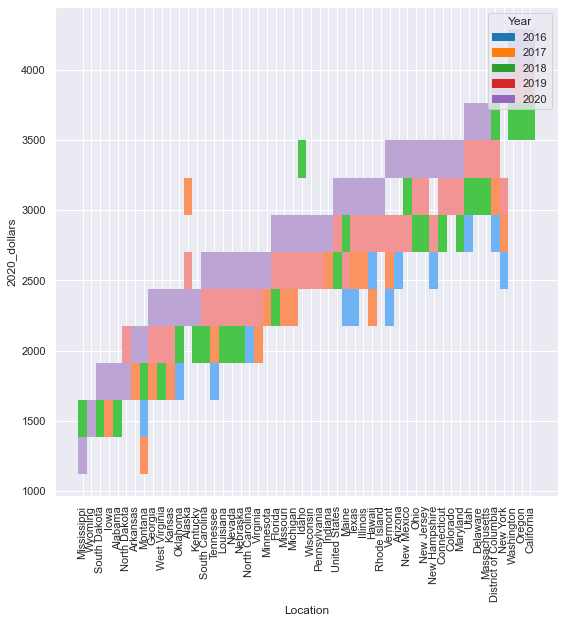

In [85]:
sns.histplot(hcpid_2016_20, x='Location', y='2020_dollars', hue='Year', palette='tab10')
plt.xticks(rotation='vertical');

In [177]:
ob_2019 = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/2019-Annual-ALL-Data.csv')
ob_2019_df = pd.DataFrame(ob_2019)
ob_2019_df = ob_2019_df.loc[ob_2019_df['Measure Name'] == re.findall()]
ob_2019_df

TypeError: expected string or bytes-like object

In [223]:
def get_ob (df):
    ob = df.loc[df['Measure Name'].str.contains('(Obesity)', regex=True)]
    ob_df = pd.DataFrame(ob)
    return ob_df

In [224]:
get_ob(ob_2019_df)

/var/folders/n9/nmyqjt296k35d4yvkrgc5nbw0000gn/T/ipykernel_8636/1101471720.py:2: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,Edition,Report Type,Measure Name,State Name,Rank,Value,Score,LowerCI,UpperCI,Source,Source Year
117,2019,2019 Annual,Obesity,United States,NaN,30.9,NaN,NaN,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018
118,2019,2019 Annual,Obesity - American Indian/Alaska Native,United States,NaN,39.0,NaN,36.2,41.9,"CDC, Behavioral Risk Factor Surveillance System",2018
119,2019,2019 Annual,Obesity - Asian,United States,NaN,11.5,NaN,10.2,12.8,"CDC, Behavioral Risk Factor Surveillance System",2018
120,2019,2019 Annual,Obesity - Black,United States,NaN,39.9,NaN,38.9,40.9,"CDC, Behavioral Risk Factor Surveillance System",2018
121,2019,2019 Annual,Obesity - Hawaiian/Pacific Islander,United States,NaN,35.2,NaN,30.6,39.8,"CDC, Behavioral Risk Factor Surveillance System",2018
122,2019,2019 Annual,Obesity - Hispanic,United States,NaN,34.2,NaN,33.1,35.4,"CDC, Behavioral Risk Factor Surveillance System",2018
123,2019,2019 Annual,Obesity - Multiracial,United States,NaN,32.0,NaN,30.1,34.0,"CDC, Behavioral Risk Factor Surveillance System",2018
124,2019,2019 Annual,Obesity - Other Race,United States,NaN,29.4,NaN,26.1,32.7,"CDC, Behavioral Risk Factor Surveillance System",2018
125,2019,2019 Annual,Obesity - White,United States,NaN,29.9,NaN,29.6,30.2,"CDC, Behavioral Risk Factor Surveillance System",2018
126,2019,2019 Annual,Obesity - Less Than High School,United States,NaN,36.6,NaN,35.3,37.8,"CDC, Behavioral Risk Factor Surveillance System",2018


In [214]:
# for i in ob_2019_df['Measure Name']:
obesity = ob_2019_df.loc[ob_2019_df['Measure Name'].str.contains('(Obesity)', regex=True)]
    # rows.append(i)
# print(i)
# ob_2019_df.loc[ob_2019_df['Measure Name'] == obesity]
obesity_df = pd.DataFrame(obesity)
obesity_df

/var/folders/n9/nmyqjt296k35d4yvkrgc5nbw0000gn/T/ipykernel_8636/1147405288.py:2: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,Edition,Report Type,Measure Name,State Name,Rank,Value,Score,LowerCI,UpperCI,Source,Source Year
117,2019,2019 Annual,Obesity,United States,NaN,30.9,NaN,NaN,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018
118,2019,2019 Annual,Obesity - American Indian/Alaska Native,United States,NaN,39.0,NaN,36.2,41.9,"CDC, Behavioral Risk Factor Surveillance System",2018
119,2019,2019 Annual,Obesity - Asian,United States,NaN,11.5,NaN,10.2,12.8,"CDC, Behavioral Risk Factor Surveillance System",2018
120,2019,2019 Annual,Obesity - Black,United States,NaN,39.9,NaN,38.9,40.9,"CDC, Behavioral Risk Factor Surveillance System",2018
121,2019,2019 Annual,Obesity - Hawaiian/Pacific Islander,United States,NaN,35.2,NaN,30.6,39.8,"CDC, Behavioral Risk Factor Surveillance System",2018
122,2019,2019 Annual,Obesity - Hispanic,United States,NaN,34.2,NaN,33.1,35.4,"CDC, Behavioral Risk Factor Surveillance System",2018
123,2019,2019 Annual,Obesity - Multiracial,United States,NaN,32.0,NaN,30.1,34.0,"CDC, Behavioral Risk Factor Surveillance System",2018
124,2019,2019 Annual,Obesity - Other Race,United States,NaN,29.4,NaN,26.1,32.7,"CDC, Behavioral Risk Factor Surveillance System",2018
125,2019,2019 Annual,Obesity - White,United States,NaN,29.9,NaN,29.6,30.2,"CDC, Behavioral Risk Factor Surveillance System",2018
126,2019,2019 Annual,Obesity - Less Than High School,United States,NaN,36.6,NaN,35.3,37.8,"CDC, Behavioral Risk Factor Surveillance System",2018


In [228]:
ob_2020 = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/2020-Annual-ALL-Data.csv')
ob_2020_df = pd.DataFrame(ob_2020)
ob_2020_df 

,Edition,Report Type,Measure Name,State Name,Rank,Value,Score,LowerCI,UpperCI,Source,Source Year
0,2020,2020 Annual,Social and Economic Factors,United States,NaN,NaN,NaN,NaN,NaN,America's Health Rankings composite measure,2020
1,2020,2020 Annual,Community and Family Safety - Annual,United States,NaN,NaN,NaN,NaN,NaN,America's Health Rankings composite measure,2020
2,2020,2020 Annual,Occupational Fatalities,United States,NaN,4.4,NaN,4.3,4.5,"U.S. Bureau of Labor Statistics, Census of Fat...",2016-2018
3,2020,2020 Annual,Public Health Funding,United States,NaN,91.0,NaN,NaN,NaN,"CDC, HRSA and Trust for America's Health",2018-2019
4,2020,2020 Annual,Violent Crime,United States,NaN,379.0,NaN,NaN,NaN,"Federal Bureau of Investigation, Uniform Crime...",2019
...,...,...,...,...,...,...,...,...,...,...,...
932,2020,2020 Annual,"Obesity - $50-$74,999",United States,NaN,33.7,NaN,32.8,34.6,"CDC, Behavioral Risk Factor Surveillance System",2019
933,2020,2020 Annual,"Obesity - $75,000 or More",United States,NaN,29.6,NaN,29.1,30.1,"CDC, Behavioral Risk Factor Surveillance System",2019
934,2020,2020 Annual,Obesity - Metro,United States,NaN,32.1,NaN,31.7,32.5,"CDC, Behavioral Risk Factor Surveillance System",2021
935,2020,2020 Annual,Obesity - Non-Metro,United States,NaN,37.7,NaN,37.0,38.3,"CDC, Behavioral Risk Factor Surveillance System",2021


In [231]:
ob_2021 = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/2021-Annual-ALL-Data.csv')
ob_2021_df = pd.DataFrame(ob_2021)
ob_2021_df 

,Edition,Report Type,Measure Name,State Name,Rank,Value,Score,LowerCI,UpperCI,Source,Source Year
0,2021,2021 Annual,Social and Economic Factors,United States,NaN,NaN,NaN,NaN,NaN,America's Health Rankings composite measure,2021
1,2021,2021 Annual,Community and Family Safety - Annual,United States,NaN,NaN,NaN,NaN,NaN,America's Health Rankings composite measure,2021
2,2021,2021 Annual,Occupational Fatalities,United States,NaN,4.2,NaN,4.1,4.3,"U.S. Bureau of Labor Statistics, Census of Fat...",2017-2019
3,2021,2021 Annual,Public Health Funding,United States,NaN,116.0,NaN,NaN,NaN,"CDC, HRSA and Trust for America's Health",2019-2020
4,2021,2021 Annual,Violent Crime,United States,NaN,379.0,NaN,NaN,NaN,"Federal Bureau of Investigation, Uniform Crime...",2019
...,...,...,...,...,...,...,...,...,...,...,...
960,2021,2021 Annual,Population Ages 65+ - Multiracial,United States,NaN,0.8,NaN,NaN,NaN,"CDC WONDER, Single-Race Population Estimates",2020
961,2021,2021 Annual,Population Ages 65+ - White,United States,NaN,75.7,NaN,NaN,NaN,"CDC WONDER, Single-Race Population Estimates",2020
962,2021,2021 Annual,Population Ages 65+ - Female,United States,NaN,55.4,NaN,NaN,NaN,"CDC WONDER, Single-Race Population Estimates",2020
963,2021,2021 Annual,Population Ages 65+ - Male,United States,NaN,44.6,NaN,NaN,NaN,"CDC WONDER, Single-Race Population Estimates",2020


In [232]:
ob_2022 = pd.read_csv('/Users/adambachrach/Desktop/Healthcare_Analysis/Analysis_Project/2022-Annual-ALL-Data.csv')
ob_2022_df = pd.DataFrame(ob_2022)
ob_2022_df 

,Edition,Report Type,Measure Name,State Name,Rank,Value,Score,LowerCI,UpperCI,Source,Source Year
0,2022,2022 Annual,Social and Economic Factors,United States,NaN,NaN,NaN,NaN,NaN,America's Health Rankings composite measure,2022
1,2022,2022 Annual,Community and Family Safety - Annual,United States,NaN,NaN,NaN,NaN,NaN,America's Health Rankings composite measure,2022
2,2022,2022 Annual,Firearm Deaths,United States,NaN,13.7,NaN,13.6,13.8,"CDC WONDER, Multiple Cause of Death Files",2020
3,2022,2022 Annual,Firearm Deaths - Female,United States,NaN,3.8,NaN,3.7,3.9,"CDC WONDER, Multiple Cause of Death Files",2020
4,2022,2022 Annual,Firearm Deaths - Male,United States,NaN,24.1,NaN,23.9,24.4,"CDC WONDER, Multiple Cause of Death Files",2020
...,...,...,...,...,...,...,...,...,...,...,...
999,2022,2022 Annual,Population Ages 65+ - Multiracial,United States,NaN,0.8,NaN,NaN,NaN,"CDC WONDER, Single-Race Population Estimates",2018
1000,2022,2022 Annual,Population Ages 65+ - White,United States,NaN,83.6,NaN,NaN,NaN,"CDC WONDER, Single-Race Population Estimates",2018
1001,2022,2022 Annual,Population Ages 65+ - Female,United States,NaN,55.5,NaN,NaN,NaN,"CDC WONDER, Single-Race Population Estimates",2018
1002,2022,2022 Annual,Population Ages 65+ - Male,United States,NaN,44.5,NaN,NaN,NaN,"CDC WONDER, Single-Race Population Estimates",2018


In [233]:
ob_2019_22 = pd.concat([ob_2019_df, ob_2020_df, ob_2021_df, ob_2022_df], sort=True)
ob_2019_22

,Edition,LowerCI,Measure Name,Rank,Report Type,Score,Source,Source Year,State Name,UpperCI,Value
0,2019,NaN,Arthritis,NaN,2019 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018,United States,NaN,26.3
1,2019,31.0,Arthritis - American Indian/Alaska Native,NaN,2019 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018,United States,36.0,33.5
2,2019,9.0,Arthritis - Asian,NaN,2019 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018,United States,11.6,10.3
3,2019,24.0,Arthritis - Black,NaN,2019 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018,United States,25.7,24.9
4,2019,12.9,Arthritis - Hawaiian/Pacific Islander,NaN,2019 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018,United States,21.4,17.2
...,...,...,...,...,...,...,...,...,...,...,...
999,2022,NaN,Population Ages 65+ - Multiracial,NaN,2022 Annual,NaN,"CDC WONDER, Single-Race Population Estimates",2018,United States,NaN,0.8
1000,2022,NaN,Population Ages 65+ - White,NaN,2022 Annual,NaN,"CDC WONDER, Single-Race Population Estimates",2018,United States,NaN,83.6
1001,2022,NaN,Population Ages 65+ - Female,NaN,2022 Annual,NaN,"CDC WONDER, Single-Race Population Estimates",2018,United States,NaN,55.5
1002,2022,NaN,Population Ages 65+ - Male,NaN,2022 Annual,NaN,"CDC WONDER, Single-Race Population Estimates",2018,United States,NaN,44.5


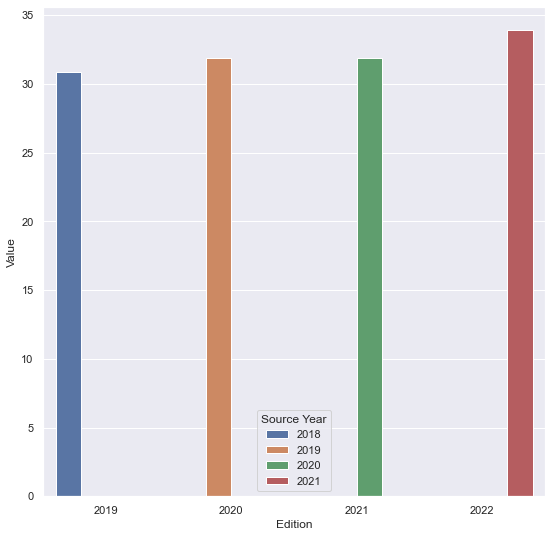

In [154]:
sns.barplot(ob_2019_22, x='Edition', y='Value', hue='Source Year');

In [237]:
get_ob(ob_2019_22)

/var/folders/n9/nmyqjt296k35d4yvkrgc5nbw0000gn/T/ipykernel_8636/1101471720.py:2: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



,Edition,LowerCI,Measure Name,Rank,Report Type,Score,Source,Source Year,State Name,UpperCI,Value
117,2019,NaN,Obesity,NaN,2019 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018,United States,NaN,30.9
118,2019,36.2,Obesity - American Indian/Alaska Native,NaN,2019 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018,United States,41.9,39.0
119,2019,10.2,Obesity - Asian,NaN,2019 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018,United States,12.8,11.5
120,2019,38.9,Obesity - Black,NaN,2019 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018,United States,40.9,39.9
121,2019,30.6,Obesity - Hawaiian/Pacific Islander,NaN,2019 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2018,United States,39.8,35.2
...,...,...,...,...,...,...,...,...,...,...,...
964,2022,37.4,"Obesity - $25-$49,999",NaN,2022 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2021,United States,39.0,38.2
965,2022,35.8,"Obesity - $50-$74,999",NaN,2022 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2021,United States,37.6,36.7
966,2022,30.9,"Obesity - $75,000 or More",NaN,2022 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2021,United States,32.1,31.5
967,2022,31.7,Obesity - Metro,NaN,2022 Annual,NaN,"CDC, Behavioral Risk Factor Surveillance System",2021,United States,32.5,32.1
